In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

# Contextualização: 

Bem-vindo à Machine Learning Housing Corporation!
A primeira tarefa que lhe é atribuída é construir um modelo de preços de imóveis na Califórnia utilizando os dados do censo da Califórnia. Esses dados contêm métricas como população, renda mediana, preço mediano dos imóveis, entre outras, para cada block group da Califórnia. Block groups são a menor unidade geográfica para a qual o US Census Bureau publica dados amostrais (um block group normalmente possui uma população entre 600 e 3.000 pessoas). Vamos chamá-los simplesmente de “distritos” para simplificar. Seu modelo deve aprender a partir desses dados e ser capaz de prever o preço mediano dos imóveis em qualquer distrito, dadas todas as outras métricas disponíveis.

A primeira pergunta que você deve fazer ao seu chefe é qual é exatamente o objetivo de negócio; construir um modelo provavelmente não é o objetivo final. Como a empresa espera usar esse modelo e se beneficiar dele? Isso é importante porque determinará como você irá formular o problema, quais algoritmos irá selecionar, qual medida de desempenho usará para avaliar o modelo e quanto esforço deverá gastar ajustando-o. Seu chefe responde que a saída do seu modelo (uma previsão do preço mediano dos imóveis de um distrito) será alimentada em outro sistema de Machine Learning (ver Figura 2-2), juntamente com muitos outros sinais. Esse sistema posterior determinará se vale a pena ou não investir em uma determinada área. Acertar isso é fundamental, pois afeta diretamente a receita.

A próxima pergunta a ser feita é como é a solução atual (se existir). Ela frequentemente fornece uma referência de desempenho, além de insights sobre como resolver o problema. Seu chefe responde que, atualmente, os preços dos imóveis por distrito são estimados manualmente por especialistas: uma equipe reúne informações atualizadas sobre um distrito e, quando não consegue obter o preço mediano dos imóveis, faz uma estimativa usando regras complexas. Esse processo é caro e demorado, e as estimativas não são muito boas; nos casos em que conseguem descobrir o preço mediano real dos imóveis, frequentemente percebem que as estimativas estavam erradas em mais de 20%. É por isso que a empresa acredita que seria útil treinar um modelo para prever o preço mediano dos imóveis de um distrito com base em outros dados sobre esse distrito. Os dados do censo parecem ser um excelente conjunto de dados para explorar esse propósito, pois incluem os preços medianos dos imóveis de milhares de distritos, além de outras informações relevantes.

Muito bem, com todas essas informações você já está pronto para começar a projetar seu sistema. Primeiro, você precisa formular o problema: ele é supervisionado, não supervisionado ou de Reinforcement Learning? É uma tarefa de classificação, regressão ou outra coisa? Você deve usar técnicas de aprendizado em lote (batch learning) ou aprendizado online?

Antes de continuar a leitura, pause e tente responder a essas perguntas por conta própria.

Você encontrou as respostas? Vamos ver: trata-se claramente de uma tarefa típica de aprendizado supervisionado, já que você recebe exemplos de treinamento rotulados (cada instância vem com a saída esperada, isto é, o preço mediano dos imóveis do distrito). Além disso, é também uma tarefa típica de regressão, pois você está tentando prever um valor numérico. Mais especificamente, este é um problema de regressão múltipla, já que o sistema usará múltiplas características para fazer a previsão (como população do distrito, renda mediana etc.). Também é um problema de regressão univariada, pois estamos tentando prever apenas um único valor para cada distrito. Se estivéssemos tentando prever múltiplos valores por distrito, seria um problema de regressão multivariada. Por fim, não há um fluxo contínuo de dados entrando no sistema, não existe uma necessidade particular de se ajustar rapidamente a dados em mudança, e o conjunto de dados é pequeno o suficiente para caber na memória. Portanto, o aprendizado em lote (batch learning) simples é mais do que suficiente.

# 1. Abrindo dataset

In [2]:
housing = pd.read_csv("../datasets/housing.csv")
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [3]:
print("Colunas do nosso dataset")
housing.columns

Colunas do nosso dataset


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

# 2. Eliminando dados categóricos

Modelos de Machine Learning trabalham com números, mas muitos dados são categóricos (texto). Nesses casos, utilizamos o One-Hot Encoding para transformar uma variável categórica em várias variáveis binárias (0 ou 1), uma para cada categoria.

In [4]:
housing["ocean_proximity"]

0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
20635      INLAND
20636      INLAND
20637      INLAND
20638      INLAND
20639      INLAND
Name: ocean_proximity, Length: 20640, dtype: object

In [5]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat = cat_encoder.fit_transform(housing[["ocean_proximity"]])

print("Variáveis categóricas agora separadas em features: ", cat_encoder.categories_[0])
print("\n")
print("Distribuição em uma matrix esparsa:")
print(housing_cat.toarray())

Variáveis categóricas agora separadas em features:  ['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


Distribuição em uma matrix esparsa:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [6]:
housing_cat_df = pd.DataFrame(
    housing_cat.toarray(),          
    columns=cat_encoder.categories_[0],  
    index=housing.index              
)

housing_cat_df

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
20635,0.0,1.0,0.0,0.0,0.0
20636,0.0,1.0,0.0,0.0,0.0
20637,0.0,1.0,0.0,0.0,0.0
20638,0.0,1.0,0.0,0.0,0.0


In [7]:
housing = housing.join(housing_cat_df)
housing = housing.drop(columns=["ocean_proximity"])
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,0.0,1.0,0.0,0.0,0.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,0.0,1.0,0.0,0.0,0.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,0.0,1.0,0.0,0.0,0.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,0.0,1.0,0.0,0.0,0.0


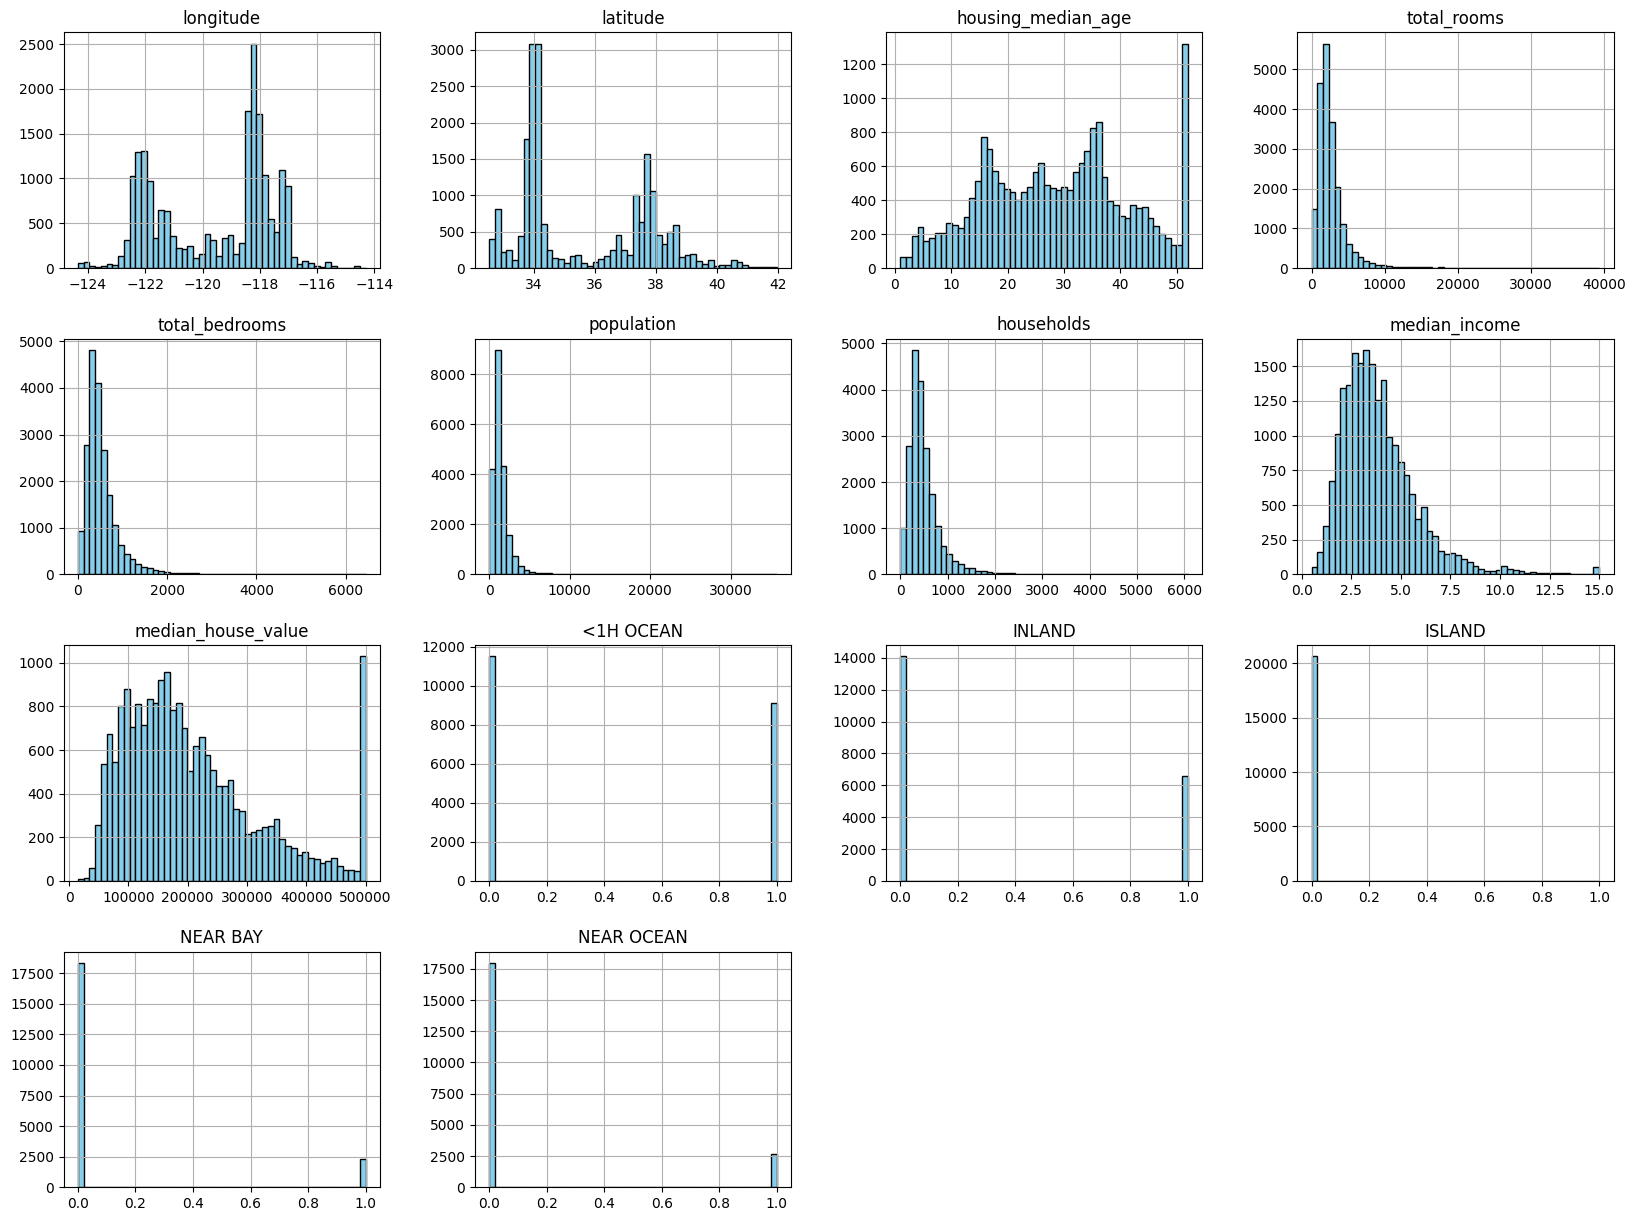

In [8]:
housing.hist(bins=50, color='skyblue', edgecolor='black', figsize=(20,15))
plt.show()

# 3. Criando um test set

## Observação: 

O trecho acima pode gerar um viés de amostragem (sampling bias). Sampling bias acontece quando o conjunto de dados usado (especialmente o de teste) não representa bem a população real. Onde exatamente está o sampling bias? Não está no algoritmo, não está no treinamento, não está nas features, **está na forma como o test set é construído**. Utilizando o trecho acima você esta assumindo que uma amostragem aleatória será representativa mas essa suposição nesse caso não é verdadeira. E por que isso quebra a avaliação? Imagine poucas regiões ricas no teste, como casas caras são difíceis de prever e o modelo normalmente erra mais nelas, o erro médio fica artificialmente baixo, logo você acha que o modelo é ótimo mas ele só foi pouco testado onde mais erra. Agora imagine o contrário, muitas regiões ricas no teste implicam em muitas casas caras, logo muitos erros grandes, assim você acha que o modelo é ruim mas ele foi testado mais forte do que deveria. 

In [10]:
# Vamos estratificar a feature median_income em categorias
housing["income_cat"] = pd.cut(
    x=housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, float('inf')],
    labels=[1, 2, 3, 4, 5])

# 0.0 a 1.5 (15k) -> 1 
# 1.5 a 3.0 -> 2 
# 3.0 a 4.5 - > 3
# 4.5 a 6.0 -> 4 
# 6.0 a inf - > 5 
housing["income_cat"]


0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [11]:
housing[housing["income_cat"] == 1].count()

longitude             822
latitude              822
housing_median_age    822
total_rooms           822
total_bedrooms        814
population            822
households            822
median_income         822
median_house_value    822
<1H OCEAN             822
INLAND                822
ISLAND                822
NEAR BAY              822
NEAR OCEAN            822
income_cat            822
dtype: int64

Text(0.5, 0, 'Category')

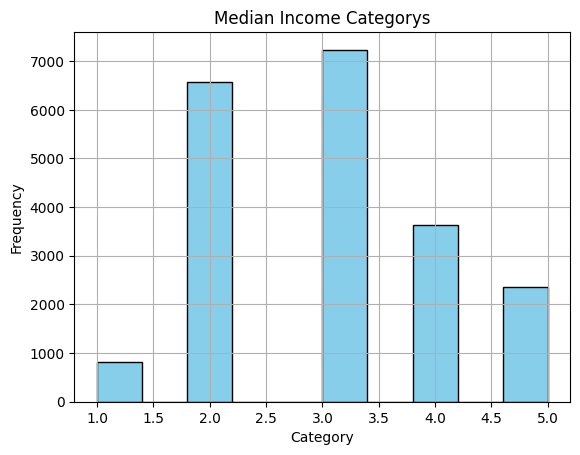

In [12]:
housing["income_cat"].hist(bins=10, color='skyblue', edgecolor='black')
plt.title("Median Income Categorys")
plt.ylabel("Frequency")
plt.xlabel("Category")

In [ ]:
# Utilizando o StratifiedShuffleSplit, um gerador de índices de treino e teste 
# que garante que a distribuição de uma variável categórica seja preservada nos dois conjuntos.

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# n_splits=1 -> Crie uma única divisão treino–teste


# o método split recebe o as features (housing) e a variável para estratificação (housing["income_cat"])
# O método split retorna um iterador (generator) de pares (train_idx, test_idx) onde cada um é um array de índices inteiros
for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    housing_train = housing.loc[train_idx]
    housing_test = housing.loc[test_idx]


<Axes: xlabel='longitude', ylabel='latitude'>

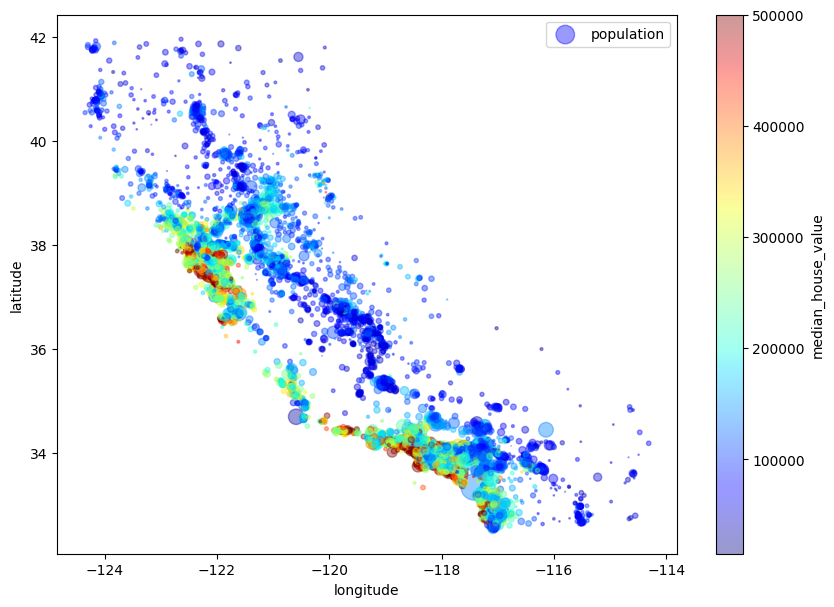

In [14]:
housing_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing_train["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

# 4. Estudando correlação

In [15]:
corr_matrix = housing_train.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,income_cat
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466,0.318160,-0.054733,0.006436,-0.475898,0.052194,-0.016281
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673,-0.444080,0.350742,-0.011606,0.358881,-0.167113,-0.078768
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146,0.048905,-0.243223,0.010369,0.258548,0.022243,-0.139314
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140,0.001089,0.023986,-0.005585,-0.027584,-0.008845,0.221745
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781,0.024756,-0.009419,-0.003549,-0.026413,0.001407,0.012635
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882,0.077911,-0.022377,-0.006498,-0.065896,-0.022142,0.022900
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590,0.048127,-0.042293,-0.005713,-0.016036,0.002781,0.035115
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151,0.167555,-0.233741,-0.006686,0.054898,0.025384,0.902151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000,0.259521,-0.482853,0.013708,0.158691,0.137332,0.642256
<1H OCEAN,0.318160,-0.444080,0.048905,0.001089,0.024756,0.077911,0.048127,0.167555,0.259521,1.000000,-0.607095,-0.009770,-0.315029,-0.341063,0.176822


In [16]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
income_cat            0.642256
<1H OCEAN             0.259521
NEAR BAY              0.158691
NEAR OCEAN            0.137332
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
ISLAND                0.013708
population           -0.026882
longitude            -0.047466
latitude             -0.142673
INLAND               -0.482853
Name: median_house_value, dtype: float64

## Observação:

Uma forma bastante interessante de visualizar graficamente as correlações entre features é através do pandas

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

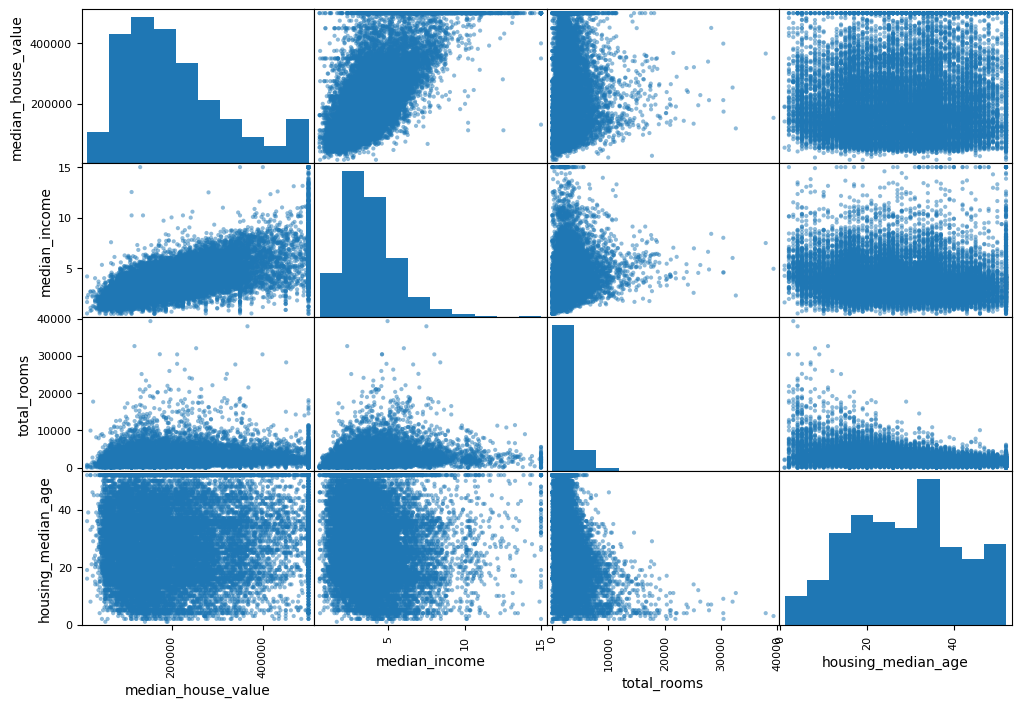

In [17]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))